In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sphviewer.tools import QuickView
import illustris_python as il
import physics


In [85]:
tng_run = "tng-100-1"
snapshot = 99
test_name = "all_data_1805"
subhalo_id = 438787
subhalos = [76086, 509103, 438787, 601952, 225155]
#subhalos = [509103]
subhalos_kappa = [509103, 271729, 225155]

In [9]:
def stars_out(tng_run, snapshot, i):
    #intitial setup
    base_path = "../data/" + str(tng_run) + "/output"
    fields = {"stars": ["Coordinates", "Potential", "Masses", "Velocities", "GFM_StellarPhotometrics"],
            }
    group_cat = pd.DataFrame({"id": [i]})
    #Load particles
    print("Loading stellar particles")

    print("Subhalo ", i)
    stars_dict = il.snapshot.loadSubhalo(base_path, snapshot, i, 'stars', fields["stars"])
    stars = il.pandasformat.dict_to_pandas(stars_dict)
    group_cat = physics.properties.group_properties(group_cat, base_path)
    group_cat = physics.properties.center_halo(stars, group_cat)
    stars = physics.properties.relative_pos_radius(stars, group_cat)
    group_cat = physics.properties.subhalo_velocity(stars, group_cat)
    stars = physics.properties.relative_velocities(stars, group_cat)
    #print(group_cat["SubhaloPosX"][0], group_cat["SubhaloPosY"][0], group_cat["SubhaloPosZ"][0])
    group_cat["SubhaloMassStellarTotal"] = stars["Masses"].sum()
    group_cat = physics.properties.half_mass_radius(stars, group_cat, rad_key="Total")
    max_rad = group_cat["SubhaloGalaxyRad"][0] + 10
    stars = stars[stars["r"] < max_rad]
    return stars

In [37]:
def cumulative_mass(stars, total_mass):
    temp = stars.copy(deep=True)
    temp.sort_values(by="r", inplace=True) #sort particles by radius
    temp = temp.reset_index(drop=True)
    temp_mass = 0
    r = temp["r"].values
    mass_func = np.zeros(len(r))
    for j in range(1, len(r)):
        mass_func[j] = mass_func[j-1] + temp["Masses"][j] #Add mass of next particle
    y = r
    x = mass_func/total_mass
    return x, y

In [84]:
def galaxy_size_limits(subhalo, group_cat, index, test_name):

    #fig1, axs1 = plt.subplots(nrows = 1, ncols = 2, figsize=(15,9), sharey=True, squeeze=True)
    fig1 = plt.figure(figsize=(13,9))
    ax = fig1.add_gridspec(4, 6, hspace=0.0, wspace=0.0)
    ax1 = fig1.add_subplot(ax[0:, 0:5])
    ax2 = fig1.add_subplot(ax[0:, -1], sharey=ax1)
    
    r_half = group_cat[group_cat["id"] == index]["SubhaloHalfmassRadStellarTotal"].values[0]
    theta = np.linspace(0, 2*np.pi, 100)
    x_half = np.cos(theta)*r_half
    y_half = np.sin(theta)*r_half
    x_half_2 = np.cos(theta)*r_half*2
    y_half_2 = np.sin(theta)*r_half*2
    x_30 = np.cos(theta)*30
    y_30 = np.sin(theta)*30
    gal_rad = group_cat[group_cat["id"] == index]["SubhaloGalaxyRad"].values[0]
    x_15r200 = np.cos(theta)*gal_rad
    y_15r200 = np.sin(theta)*gal_rad
    
    max_rad = max([gal_rad, 30, r_half*2])
    total_mass = group_cat[group_cat["id"] == index]["SubhaloMassStellarTotal"].values[0]

    pos_xyz = np.transpose([subhalo["x_rot"], subhalo["y_rot"], subhalo["z_rot"]])
    pos_xzy = np.transpose([subhalo["x_rot"], subhalo["z_rot"], subhalo["y_rot"]])

    qv_xy = QuickView(pos_xyz, r='infinity', plot=False)
    ax1.imshow(qv_xy.get_image(), extent=qv_xy.get_extent(), cmap="bone")
    ax1.plot(x_half_2, y_half_2, '-', linewidth=3, label=r'$2 \times r_{hm}$', color="#fec44f")
    ax1.plot(x_30, y_30, '--', linewidth=3, label=r'30 kpc', color="#fe9929")
    ax1.plot(x_15r200, y_15r200, ':', linewidth=3, label=r'$15 \times r_{200}$', color="#d95f0e")
    log_mass = np.round(np.log10(10**10*total_mass/0.67), 2)
    ax1.text(-max_rad*0.97, -max_rad*0.97, r"$M_\ast^{SF}$ = " + str(log_mass), fontsize=26, color="white")
    
    mass, rad = cumulative_mass(subhalo, total_mass)
    ax2.plot(mass, rad, c="#ff7f00", linewidth=4)
    ax2.plot(mass, -rad, c="#ff7f00", linewidth=4)
    ax2.set(ylim=(-max_rad - 5, max_rad + 5))
    ax2.tick_params(which="both", direction="inout", labelleft = False, 
                    top=True, right=True, labelsize=20, pad=15, length=4, width=2)

    il.formatplot.rot_galaxy_map(ax1, max_rad + 5, "x", "y")
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True, fontsize=16)
    ax1.set_facecolor("black")
    
    fig1.subplots_adjust(hspace=0, wspace=0)
    fig1.tight_layout()
    plt.show()
    
    folder_path = "../fig/galaxy_sizes/"
    file_path = "galaxy_size_" + str(index) + ".png"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    plt.savefig(folder_path + file_path)
    


In [11]:
def create_projections_SPH(subhalo, group_cat, index, test_name, ax1, ax2):
    
    r_half = group_cat[group_cat["id"] == index]["SubhaloHalfmassRadStellar"].values[0]
    theta = np.linspace(0, 2*np.pi, 100)
    x_half = np.cos(theta)*r_half
    y_half = np.sin(theta)*r_half
    x_half_3 = np.cos(theta)*r_half*3
    y_half_3 = np.sin(theta)*r_half*3

    pos_xyz = np.transpose([subhalo["x_rot"], subhalo["y_rot"], subhalo["z_rot"]])
    pos_xzy = np.transpose([subhalo["x_rot"], subhalo["z_rot"], subhalo["y_rot"]])

    qv_xy = QuickView(pos_xyz, r='infinity', plot=False)
    ax1.imshow(qv_xy.get_image(), extent=qv_xy.get_extent(), cmap="bone")
    ax1.plot(x_half, y_half, '--', label=r'$r_{half}$',color="orange")
    ax1.plot(x_half_3, y_half_3, '-', label=r'$3 r_{half}$', color="orange")
    
    qv_xz = QuickView(pos_xzy, r='infinity', plot=False)
    ax2.imshow(qv_xz.get_image(), extent=qv_xz.get_extent(), cmap="bone")
    ax2.plot(x_half, y_half, '--', label=r'$r_{half}$', color="orange")
    ax2.plot(x_half_3, y_half_3, '-', label=r'$3 r_{half}$', color="orange")
    
    return ax1, ax2



Loading stellar particles
Subhalo  509103
45196
71661.74919681263 12720.565795638076 31219.570000544965
Loading stellar particles
Subhalo  271729
479255
19998.189839825758 55134.030903595994 61005.45957062844
Loading stellar particles
Subhalo  225155
798437
2321.4203714292216 16720.82319588666 24163.02076918521


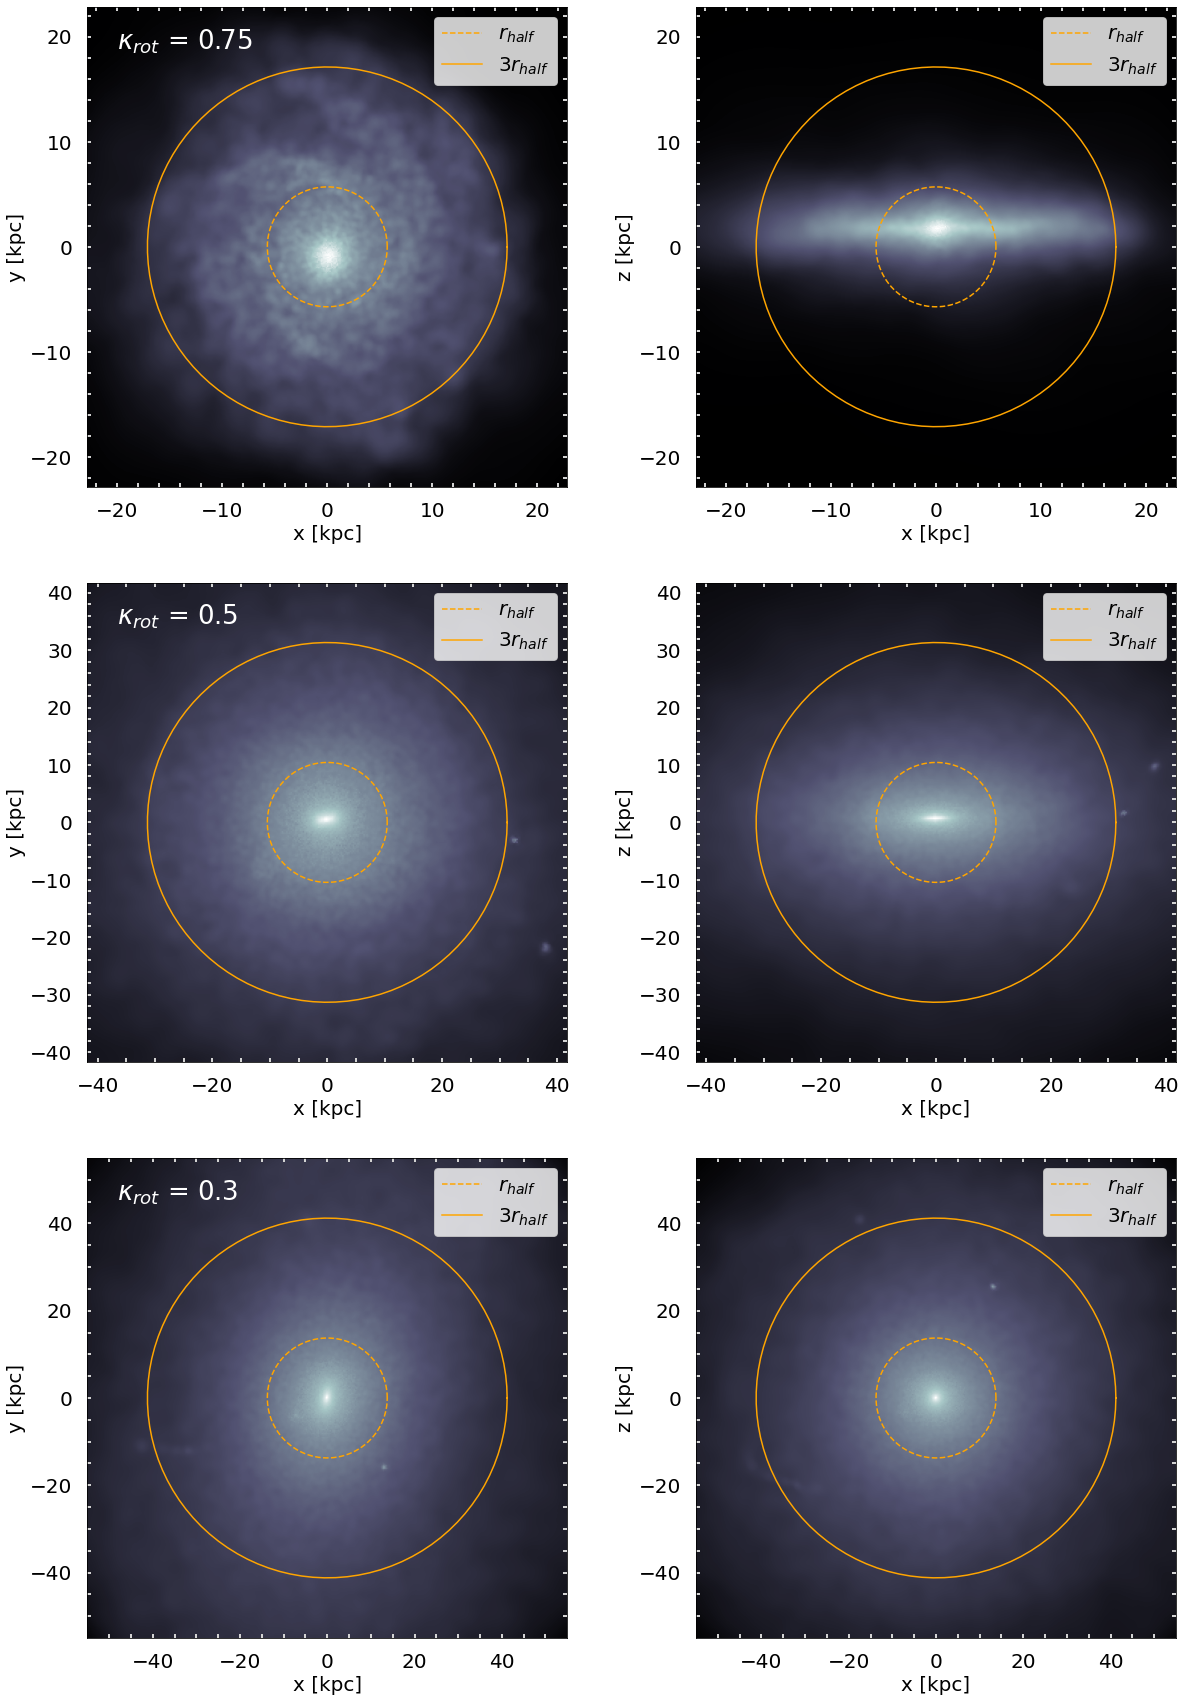

In [19]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize=(20,30))

i = 0
kappas = [0.75, 0.50, 0.30]
for subhalo_id in subhalos_kappa:
    new_cat_path = "../data/" + tng_run + "/catalogues/" + test_name + ".pkl"
    group_cat = pd.read_pickle(new_cat_path)
    subhalo_index = group_cat[group_cat["id"] == subhalo_id].index.values.astype(int)[0]
    rot_vector = np.transpose(np.array([group_cat["AngularMomentumX15Rvir"][subhalo_index],
        group_cat["AngularMomentumY15Rvir"][subhalo_index],
        group_cat["AngularMomentumZ15Rvir"][subhalo_index]]))
    subhalo = stars_out(tng_run, snapshot, subhalo_id)
    subhalo = physics.geometry.rotate_coordinates(subhalo, rot_vector)
    create_projections_SPH(subhalo, group_cat, subhalo_id, test_name, axs[i][0], axs[i][1])
    r_half = group_cat[group_cat["id"] == subhalo_id]["SubhaloHalfmassRadStellar"].values[0]
    axs[i][0].text(-r_half*3.5, +r_half*3.3, r"$\kappa_{rot}$ = " + str(kappas[i]), fontsize=26, color="white")
    il.formatplot.rot_galaxy_map(axs[i][0], r_half*4, "x", "y")
    il.formatplot.rot_galaxy_map(axs[i][1], r_half*4, "x", "z")
    i = i + 1
    
folder_path = "../fig/projections/"
file_path = "kappa_rot.png"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
plt.savefig(folder_path + file_path)

Loading stellar particles
Subhalo  76086
1013954
36771.98057884672 937.574047139254 70503.4659197319


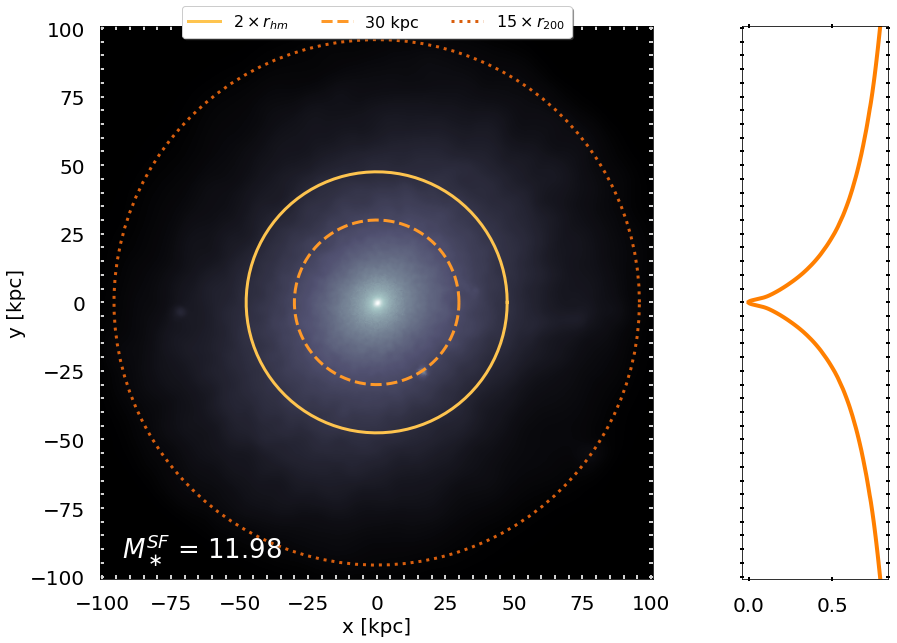

Loading stellar particles
Subhalo  509103
45196
71661.74919681263 12720.565795638076 31219.570000544965


<Figure size 432x288 with 0 Axes>

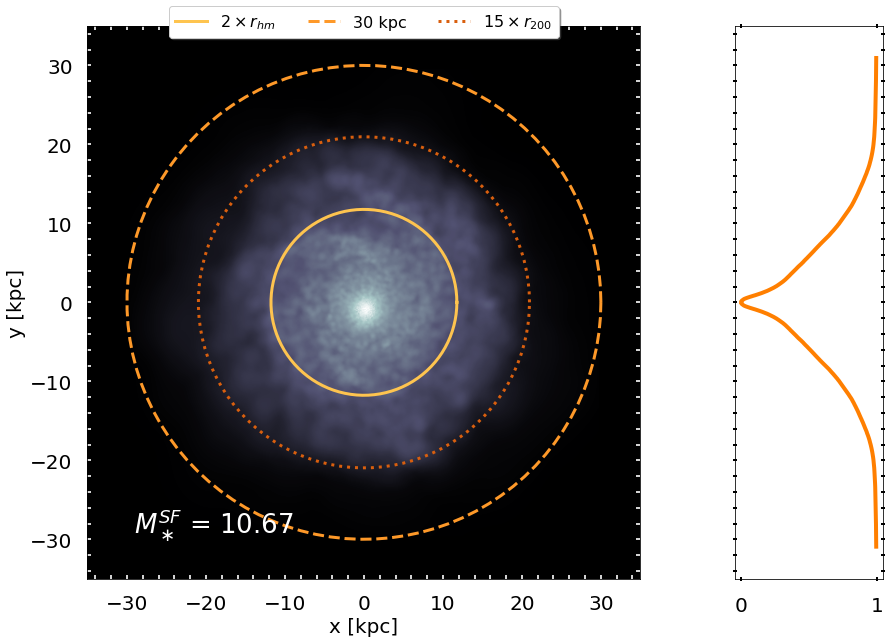

Loading stellar particles
Subhalo  438787
53966
28190.498004367055 42788.261831517 16434.816384696926


<Figure size 432x288 with 0 Axes>

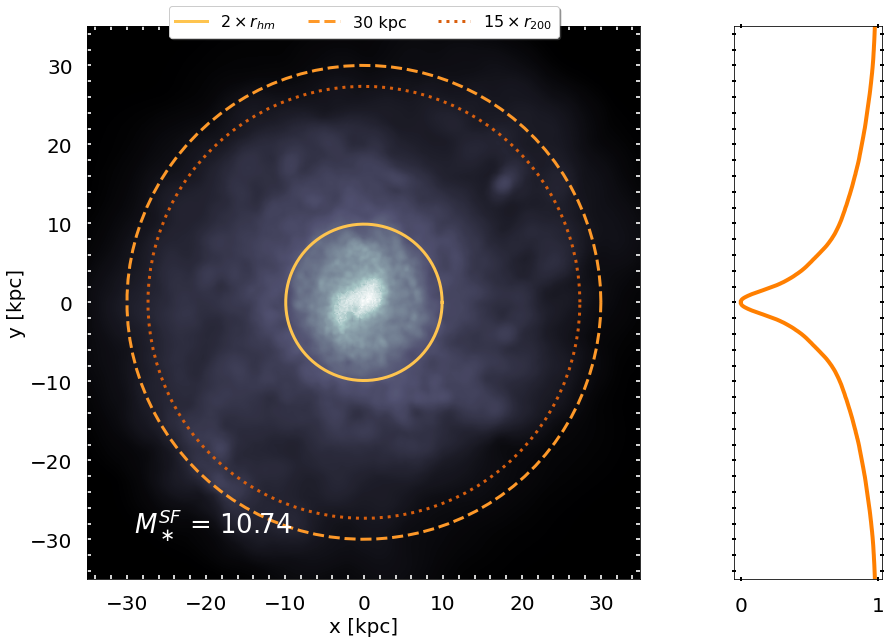

Loading stellar particles
Subhalo  601952
8783
1194.791395735011 20562.793934804697 21942.456341287038


<Figure size 432x288 with 0 Axes>

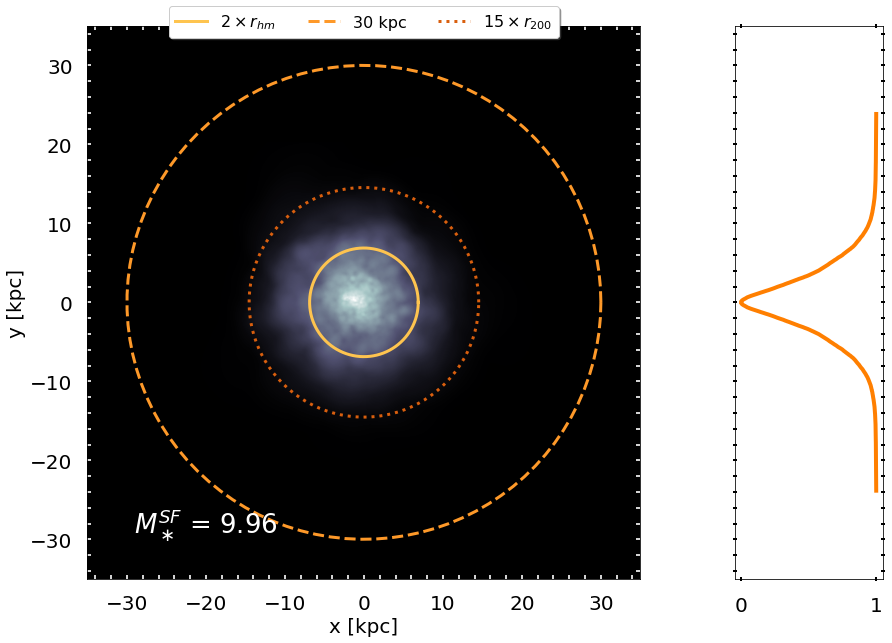

Loading stellar particles
Subhalo  225155
798437
2321.4203714292216 16720.82319588666 24163.02076918521


<Figure size 432x288 with 0 Axes>

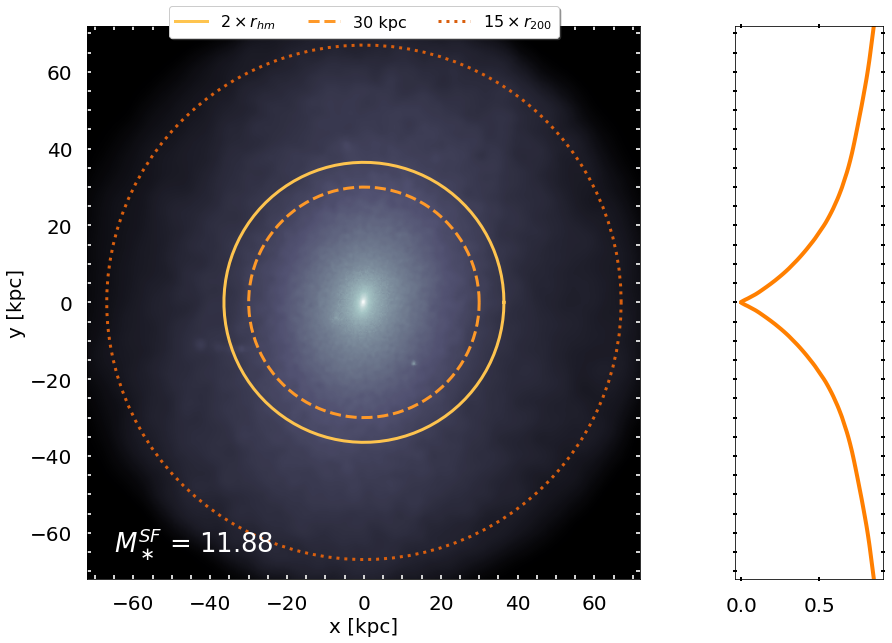

<Figure size 432x288 with 0 Axes>

In [86]:
for subhalo_id in subhalos:
    new_cat_path = "../data/" + tng_run + "/catalogues/" + test_name + ".pkl"
    group_cat = pd.read_pickle(new_cat_path)
    stellar_mass = group_cat["SubhaloMassStellarTotal"]
    #print(group_cat.keys())
    subhalo_index = group_cat[group_cat["id"] == subhalo_id].index.values.astype(int)[0]
    rot_vector = np.transpose(np.array([group_cat["AngularMomentumX15Rvir"][subhalo_index],
        group_cat["AngularMomentumY15Rvir"][subhalo_index],
        group_cat["AngularMomentumZ15Rvir"][subhalo_index]]))
    subhalo = stars_out(tng_run, snapshot, subhalo_id)
    subhalo = physics.geometry.rotate_coordinates(subhalo, rot_vector)
    galaxy_size_limits(subhalo, group_cat, subhalo_id, test_name)

Loading stellar particles
Subhalo  509103
45196
71661.74919681263 12720.565795638076 31219.570000544965


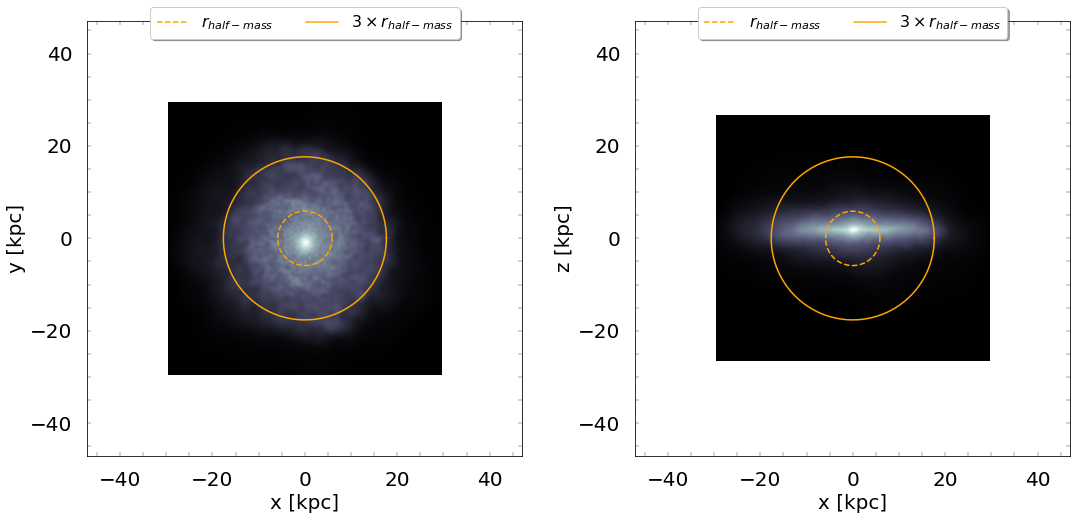

In [29]:
subhalo_id = 509103
new_cat_path = "../data/" + tng_run + "/catalogues/" + test_name + ".pkl"
group_cat = pd.read_pickle(new_cat_path)
subhalo_index = group_cat[group_cat["id"] == subhalo_id].index.values.astype(int)[0]
rot_vector = np.transpose(np.array([group_cat["AngularMomentumX15Rvir"][subhalo_index],
    group_cat["AngularMomentumY15Rvir"][subhalo_index],
    group_cat["AngularMomentumZ15Rvir"][subhalo_index]]))
subhalo = stars_out(tng_run, snapshot, subhalo_id)
subhalo = physics.geometry.rotate_coordinates(subhalo, rot_vector)
pos_xyz = np.transpose([subhalo["x_rot"], subhalo["y_rot"], subhalo["z_rot"]])
pos_xzy = np.transpose([subhalo["x_rot"], subhalo["z_rot"], subhalo["y_rot"]])

r_half = group_cat[group_cat["id"] == subhalo_id]["SubhaloHalfmassRadStellarTotal"].values[0]
theta = np.linspace(0, 2*np.pi, 100)
x_half = np.cos(theta)*r_half
y_half = np.sin(theta)*r_half
x_half_3 = np.cos(theta)*r_half*3
y_half_3 = np.sin(theta)*r_half*3

fig1, axs1 = plt.subplots(nrows = 1, ncols = 2, figsize=(18,8))

qv_xy = QuickView(pos_xyz, r='infinity',plot=False)
axs1[0].imshow(qv_xy.get_image(), extent=qv_xy.get_extent(), cmap="bone")
axs1[0].plot(x_half, y_half, '--', label=r'$r_{half-mass}$',color="orange")
axs1[0].plot(x_half_3, y_half_3, '-', label=r'$3\times r_{half-mass}$', color="orange")

qv_xz = QuickView(pos_xzy, r='infinity', plot=False)
axs1[1].imshow(qv_xz.get_image(), extent=qv_xz.get_extent(), cmap="bone")
axs1[1].plot(x_half, y_half, '--', label=r'$r_{half-mass}$', color="orange")
axs1[1].plot(x_half_3, y_half_3, '-', label=r'$3\times r_{half-mass}$', color="orange")

il.formatplot.rot_galaxy_map(axs1[0], r_half*2, "x", "y")
axs1[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True, fontsize=16)
il.formatplot.rot_galaxy_map(axs1[1], r_half*2, "x", "z")
axs1[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True, fontsize=16)
#plt.savefig("../fig/disk_galaxy.png")